<span style="color:purple;font-weight:300;font-size:30px"> 
Food.com - Analysis of user interactions, recipes and reviews
</span>

___________

# Table of Contents
* Graph Network: Creation and analysis
* Communities analysis
* NLP analysis of reviews


# Graph Network
- Create edges and plot graph
- Preliminary analysis
- Community detection and wordclouds
___________________

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import os
import sys
sys.path.append(os.path.abspath("../Notebooks"))
from helper_functions import  *
from tqdm import tqdm

In [51]:
#from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
from itertools import count,combinations

from statistics import mean
from scipy import stats

In [52]:
import networkx

## Import Data

In [53]:
# Read compressed csv with built-in gzip support
df_recipes = decompress_pickle('../Data/file4.pbz2') 
df_ingredients = pd.read_csv('../Data/ingredients_with_recipies.csv')
df_reviews = decompress_pickle('../Data/reviews_zipped.pbz2') 

In [54]:
df_recipes.head()
#print(df_recipes.shape)

,name,id,minutes,ingredients,n_ingredients,ingredient_ids
0,arriba baked winter squash mexican style,137739,55,"[winter squash, mexican seasoning, mixed spice...",7,"[7933, 4694, 4795, 3723, 840, 5006, 6270]"
1,a bit different breakfast pizza,31490,30,"[prepared pizza crust, sausage patty, eggs, mi...",6,"[5481, 6324, 2499, 4717, 6276, 1170]"
2,alouette potatoes,59389,45,"[spreadable cheese with garlic and herbs, new ...",11,"[1170, 4918, 6426, 5185, 7099, 5006, 6009, 627..."
3,apple a day milk shake,5289,0,"[milk, vanilla ice cream, frozen apple juice c...",4,"[4717, 7474, 2946, 150]"
4,aww marinated olives,25274,15,"[fennel seeds, green olives, ripe olives, garl...",9,"[2587, 3437, 5002, 3184, 5324, 5068, 5058, 131..."


In [55]:
print(df_ingredients.shape)
print(df_reviews.shape)

(11659, 9)


In [57]:
# Convert to dtype and check 
df_reviews['date'] = pd.to_datetime(df_reviews['date'])

# Filter years 2017 + 2018 as our final subset 
df_reviews_filter = df_reviews[df_reviews['date'].dt.strftime('%Y') > '2016']

user_id               int64
recipe_id             int64
date         datetime64[ns]
rating                int64
review               object
dtype: object

## Create edges

In [60]:
recipes_user_dict={id: [] for id in df_recipes['id'].unique()}
print(len(recipes_user_dict))
recipe_error = []


for idx, row in tqdm(df_reviews_filter.iterrows()): 
    try:
        #for ingredient in row['ingredient_ids']:
        recipes_user_dict[row['recipe_id']].append(row['user_id'])
    except:
        recipe_error.append(row['recipe_id'])


# All possible pairs in List using combinations()
edges_ru = [(x,y, {"recipe_id": key})  for key in recipes_user_dict for x, y in list(combinations(recipes_user_dict[key], 2))]   


178265


47709it [00:02, 22892.28it/s]


In [61]:
banana_bread_users= df_reviews_filter[df_reviews_filter['user_id'].isin(df_reviews_filter[df_reviews_filter['recipe_id']==2886]['user_id'])]['user_id']

<AxesSubplot:>

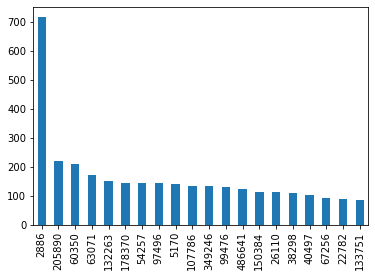

In [62]:
df_reviews_filter['recipe_id'].value_counts().head(20).plot.bar()

## Create Graph

In [63]:
#!pip install networkx
import networkx as nx

G = nx.MultiDiGraph()
G.add_nodes_from(np.unique(df_reviews_filter['user_id'].values))
print(G)

G.add_edges_from(edges_ru)
print(G)



MultiDiGraph with 38250 nodes and 0 edges
MultiDiGraph with 38250 nodes and 590460 edges


In [64]:
df_graph=pd.DataFrame()
df_graph['user_id']=(np.unique(df_reviews_filter['user_id'].values))

# Graph analysis

___________

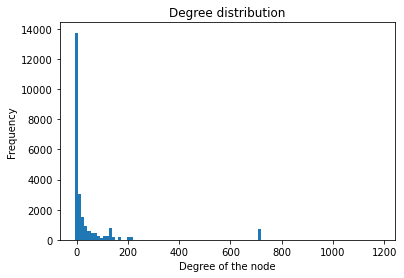

Slope of distribution: -0.9477423223385324


In [65]:

# In and out degree distributions & slope estimate(W5)
def plot_deg_dist(G, title = str):

    degree_list = [val for (node, val) in G.degree() if val != 0]

    counts, edges = np.histogram(degree_list, bins = 100)
    plt.bar(edges[:-1], counts, width=np.diff(edges))
    plt.title(title)
    plt.xlabel('Degree of the node')
    plt.ylabel('Frequency')
    plt.show()
    idx = np.isfinite(np.log(edges[:10])) & np.isfinite(np.log(counts[:10]))
    slope, intercept = np.polyfit(np.log(edges[:10])[idx], np.log(counts[:10])[idx], 1)
    print(f'Slope of distribution: {slope}')

plot_deg_dist(G, title = 'Degree distribution')  
    

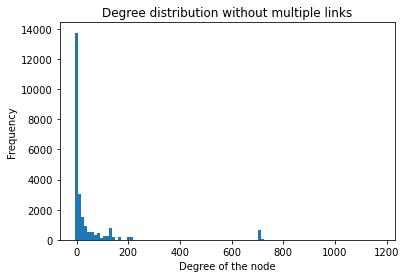

Slope of distribution: -0.9447117454222944


In [66]:
G2 = nx.Graph(G)
plot_deg_dist(G2, title = 'Degree distribution without multiple links')  

In [67]:
# Obtain largest component
largest_cc = max(nx.connected_components(G2))
GCC = G2.subgraph(largest_cc).copy()

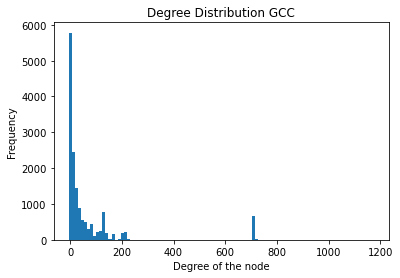

Slope of distribution: -0.7595052310486371


In [68]:
plot_deg_dist(GCC, title = 'Degree Distribution GCC')

In [69]:
degree_list = [val for (node, val) in GCC.degree()]
# Calculate stats
mean = np.mean(degree_list)
median = np.median(degree_list)
mode = stats.mode(degree_list)[0]
d_min = np.min(degree_list)
d_max = np.max(degree_list)

print(f"Mean: {mean}")
print(f'Median:{median}')
print(f'Mode:{mode}')
print(f'Min:{d_min}')
print(f'Max:{d_max}')

Mean: 74.61309562823622
Median:21.0
Mode:[715]
Min:1
Max:1179


In [70]:
# df with reviews for recipies that are a part of the graph

GCC_multi=G.subgraph(GCC.nodes)


nodes_gcc = [node for node in GCC.nodes]
recipies = [recipe['recipe_id'] for node1, node2, recipe in GCC_multi.edges(data=True)]

df_graph_reviews = df_reviews_filter[df_reviews_filter['user_id'].isin(nodes_gcc) & df_reviews_filter['recipe_id'].isin(recipies)]

In [71]:
#Statistics on number of reviews per user

mean = np.mean(df_graph_reviews['user_id'].value_counts())
median = np.median(df_graph_reviews['user_id'].value_counts())
mode = stats.mode(df_graph_reviews['user_id'].value_counts())[0]
d_min = np.min(df_graph_reviews['user_id'].value_counts())
d_max = np.max(df_graph_reviews['user_id'].value_counts())

print(f"Mean: {mean}")
print(f'Median:{median}')
print(f'Mode:{mode}')
print(f'Min:{d_min}')
print(f'Max:{d_max}')

Mean: 1.256275807825916
Median:1.0
Mode:[1]
Min:1
Max:87


In [72]:
#Statistics on number of reviews per recipe

mean = np.mean(df_graph_reviews['recipe_id'].value_counts())
median = np.median(df_graph_reviews['recipe_id'].value_counts())
mode = stats.mode(df_graph_reviews['recipe_id'].value_counts())[0]
d_min = np.min(df_graph_reviews['recipe_id'].value_counts())
d_max = np.max(df_graph_reviews['recipe_id'].value_counts())

print(f"Mean: {mean}")
print(f'Median:{median}')
print(f'Mode:{mode}')
print(f'Min:{d_min}')
print(f'Max:{d_max}')

Mean: 7.552009456264775
Median:3.0
Mode:[2]
Min:2
Max:716


## Plot Graph with Force Atlas

In [26]:
def plot_graph_fa(G,iterations, edge_color, node_color, title):

    forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=2.0,

                        # Performance
                        jitterTolerance=7.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.6,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=15.0,

                        # Log
                        verbose=True)



    # Gets positions of the nodes 
    positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=iterations)

    # Node size dictionary according to degrees
    d = dict(nx.degree(G))

    # Create color mapping dictionary
    #mapping = {"Marvel": 'red', "DC": 'black'}
    #colors = [mapping[GCC_U.nodes[n]['universe']] for n in GCC_U.nodes()]



    # Plot the Network 
    plt.figure(3,figsize=(25,25)) 
    nc = nx.draw_networkx_nodes(G, 
                        positions, 
                        node_size=[v * 0.1 for v in d.values()], 
                        #node_size = 10,
                        label=True,  
                        node_color=node_color,
                        #cmap=plt.cm.plasma_r, 
                        )

    ec = nx.draw_networkx_edges(G, 
                                positions, 
                                edge_color="#ECC836", 
                                alpha=0.2)

    plt.axis('off')
    plt.title(title, size = 20)
    plt.show()

    

    return None

100%|██████████| 2000/2000 [08:11<00:00,  4.07it/s]


BarnesHut Approximation  took  228.85  seconds
Repulsion forces  took  196.00  seconds
Gravitational forces  took  0.23  seconds
Attraction forces  took  52.39  seconds
AdjustSpeedAndApplyForces step  took  6.50  seconds


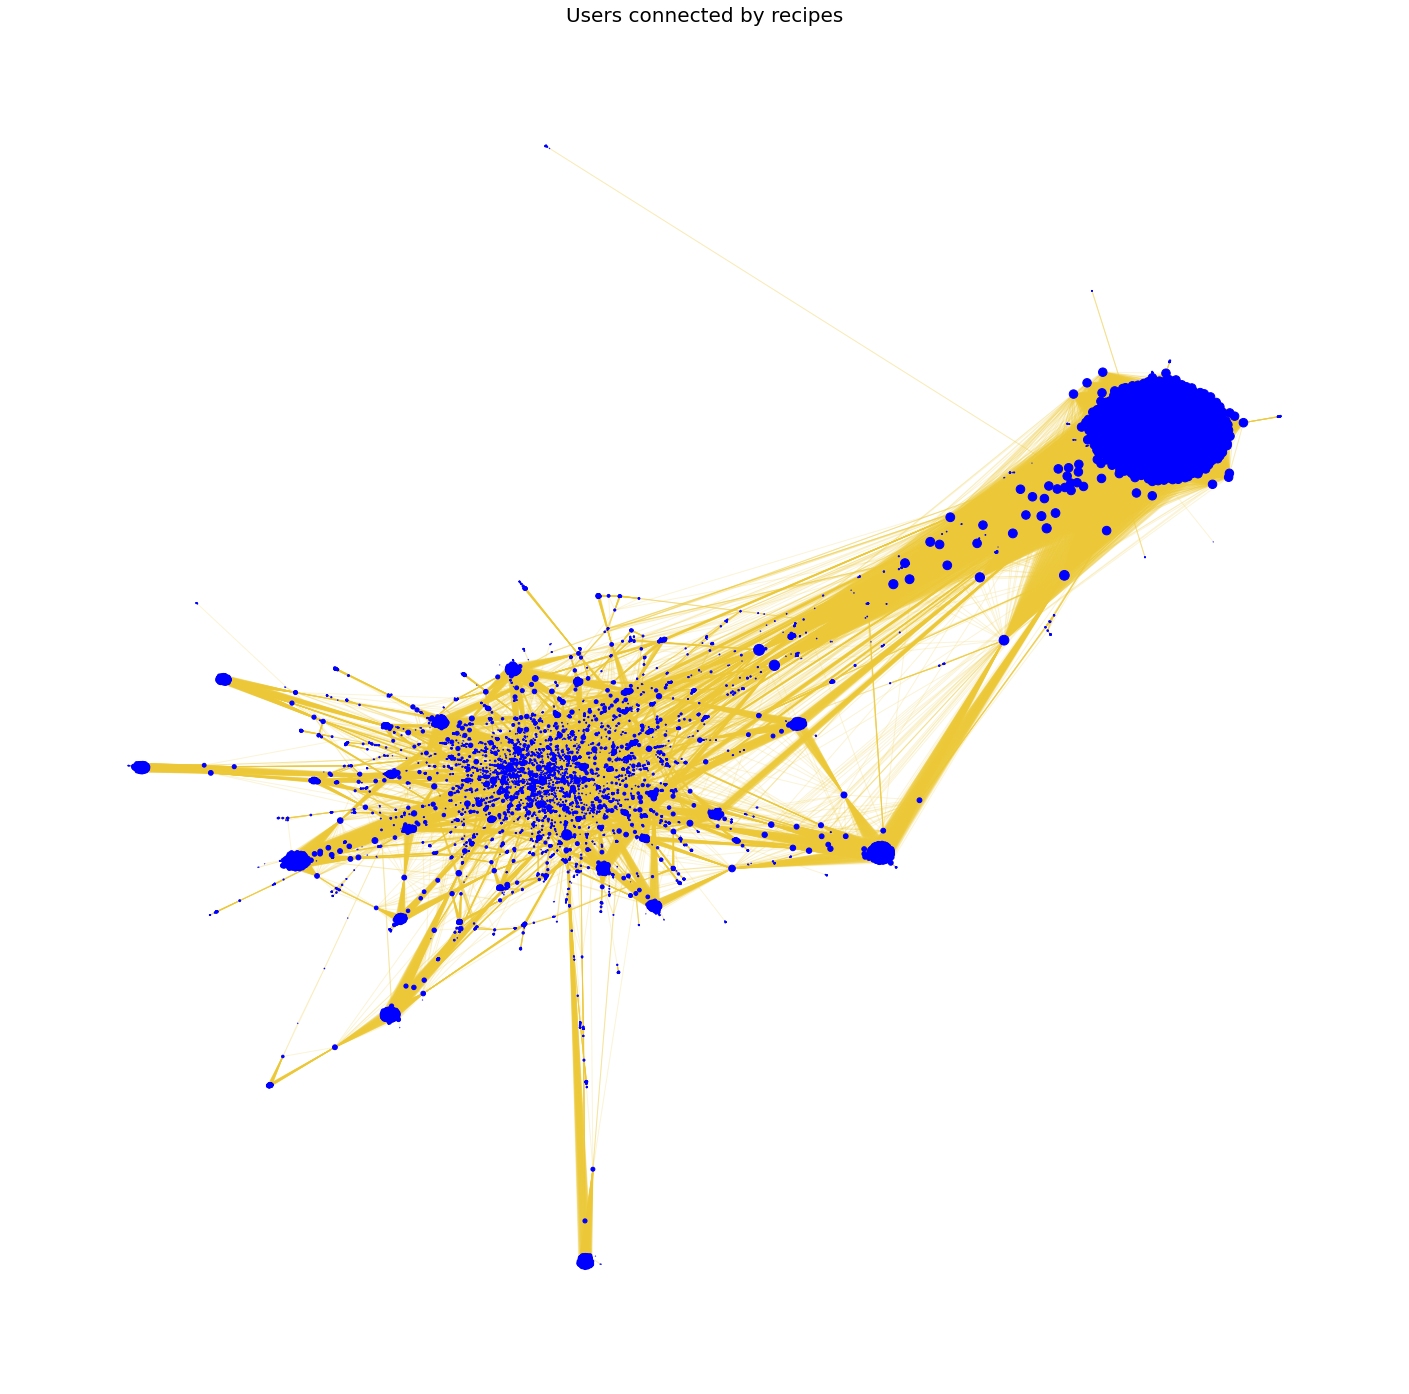

In [29]:
plot_graph_fa(GCC, iterations = 2000, edge_color="#ECC836",node_color='blue', title = 'Users connected by recipes')

# Communities detection

_____________________

In [73]:
%pip install python-louvain
import community.community_louvain as community

Note: you may need to restart the kernel to use updated packages.


In [75]:
'''
Creating partitions

# first compute the best partition for GCC
partition = community.best_partition(GCC)

# find modularity
M = community.modularity(partition, GCC)
print(f"Users graph modularity = {M} - found using community.modularity function")

from collections import Counter

#communities stats
count = Counter(partition.values())
print(f"Number of communities: {len(count)}")

from collections import Counter
count_size = Counter(count.values())

for key in count_size:
    print(f"{count_size[key]} communities of size {key} nodes was found")

largest_10_communities=sorted(count.items(), key=lambda item: item[1])[-10:]

#save partition
def dict_save(dict_partition):
    with open('../Data/partition' + '.pickle', 'wb') as f:
        pickle.dump(dict_partition, f, pickle.HIGHEST_PROTOCOL)

dict_save(partition)

'''
#load previously found partition

import pickle


def dict_partition_load():
    with open('../Data/partition' + '.pickle', 'rb') as f:
        return pickle.load(f)

partition=dict_partition_load()



Users graph modularity = 0.7604035589881257 - found using community.modularity function
Number of communities: 69
1 communities of size 773 nodes was found
1 communities of size 859 nodes was found
1 communities of size 553 nodes was found
1 communities of size 386 nodes was found
1 communities of size 554 nodes was found
1 communities of size 737 nodes was found
1 communities of size 217 nodes was found
1 communities of size 179 nodes was found
1 communities of size 199 nodes was found
1 communities of size 472 nodes was found
1 communities of size 518 nodes was found
1 communities of size 250 nodes was found
1 communities of size 480 nodes was found
1 communities of size 220 nodes was found
1 communities of size 14 nodes was found
1 communities of size 397 nodes was found
1 communities of size 318 nodes was found
1 communities of size 74 nodes was found
1 communities of size 252 nodes was found
1 communities of size 359 nodes was found
1 communities of size 164 nodes was found
1 comm

## Visualize graph with communities

100%|██████████| 1000/1000 [06:39<00:00,  2.50it/s] 


BarnesHut Approximation  took  178.38  seconds
Repulsion forces  took  171.74  seconds
Gravitational forces  took  0.22  seconds
Attraction forces  took  39.45  seconds
AdjustSpeedAndApplyForces step  took  3.96  seconds


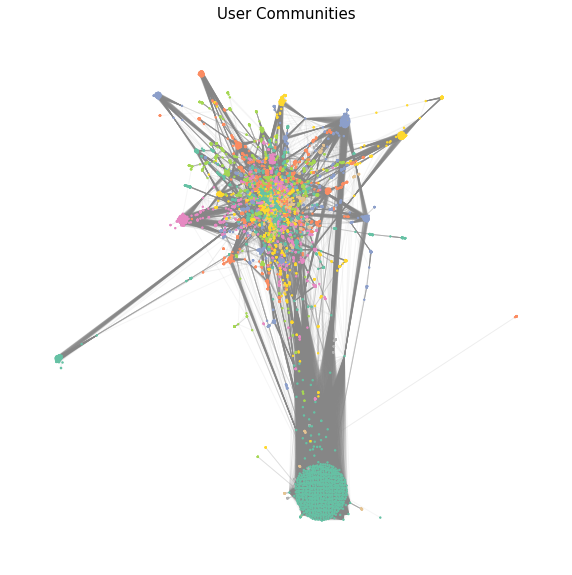

In [34]:
# Visualize with Force Atlas
import matplotlib.cm as cm

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=2.0,

                        # Performance
                        jitterTolerance=7.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.6,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=15.0,

                        # Log
                        verbose=True)

# Gets positions of the nodes 
positions = forceatlas2.forceatlas2_networkx_layout(GCC, pos=None, iterations=1000)

plt.figure(3,figsize=(10,10)) 

# color the nodes according to their partition
cmap = cm.get_cmap('Set2', max(partition.values()) + 1)

nc = nx.draw_networkx_nodes(GCC, 
                       positions, 
                       node_size=2.0, 
                       label=True,  
                       node_color=list(partition.values()),
                       cmap=cmap, 
                       )

ec = nx.draw_networkx_edges(GCC, 
                            positions, 
                            edge_color='gray', 
                            alpha=0.07)

plt.axis('off')
plt.title('User Communities', size = 15)
plt.show()

In [29]:
df_graph['community'] = df_graph['user_id'].map(partition)
df_graph= df_graph.dropna()

df_graph.shape

# Save the df with the community numbers 
df_graph.to_csv('user_community_map.csv', index=False)

In [30]:
 # Take the largest 10 
largest_com = dict(df_graph['community'].value_counts().head(10))
list_largest_com = list(largest_com.keys())
print(f'The 10 largest communities are: {list_largest_com}')

The 10 largest communities are: [16.0, 5.0, 3.0, 40.0, 1.0, 26.0, 4.0, 48.0, 2.0, 32.0]


In [31]:
#Make a subgraph for community

nodes_c1=df_graph[df_graph['community']==list_largest_com [0]]['user_id']

G_C1=G.subgraph(nodes_c1)
print(G_C1)

#find 
recipies = [recipe['recipe_id'] for node1, node2, recipe in G_C1.edges(data=True)]

c1_recipies=np.unique(np.array(recipies))
len(c1_recipies)

#IN PROGRESS - Ingredients workcloudszx

df_recipes['ingredients_str'] = df_recipes['ingredients'].apply(lambda x: ' '.join(x))
ing=''.join(''.join(df_recipes[df_recipes['id'].isin(c1_recipies)].ingredients_str.values))

MultiDiGraph with 894 nodes and 4794 edges


In [32]:

from wordcloud import WordCloud
df_recipes['ingredients_str'] = df_recipes['ingredients'].apply(lambda x: ' '.join(x))


def community_subgraph(community_idx):

    #make a subgraph for community
    nodes_c1=df_graph[df_graph['community']==community_idx]['user_id']
    G_C1=G.subgraph(nodes_c1)
    #print(G_C1)

    return G_C1



## Plotting each community graph alone

In [ ]:
# Plotting the communities graphs

#////// TODO  plot all of them, for some reason sometimes the kernel blocks - Lu


com_graphs = {}

for community_idx in list_largest_com:
    GC_subgraph = community_subgraph(community_idx)
    com_graphs[community_idx] = GC_subgraph


# list(com_graphs.values())[0]

#plot_graph_fa(list(com_graphs.values())[0], iterations = 1000, edge_color="#ECC836",node_color='blue', title = 'Users Community 1')

## Community wordclouds

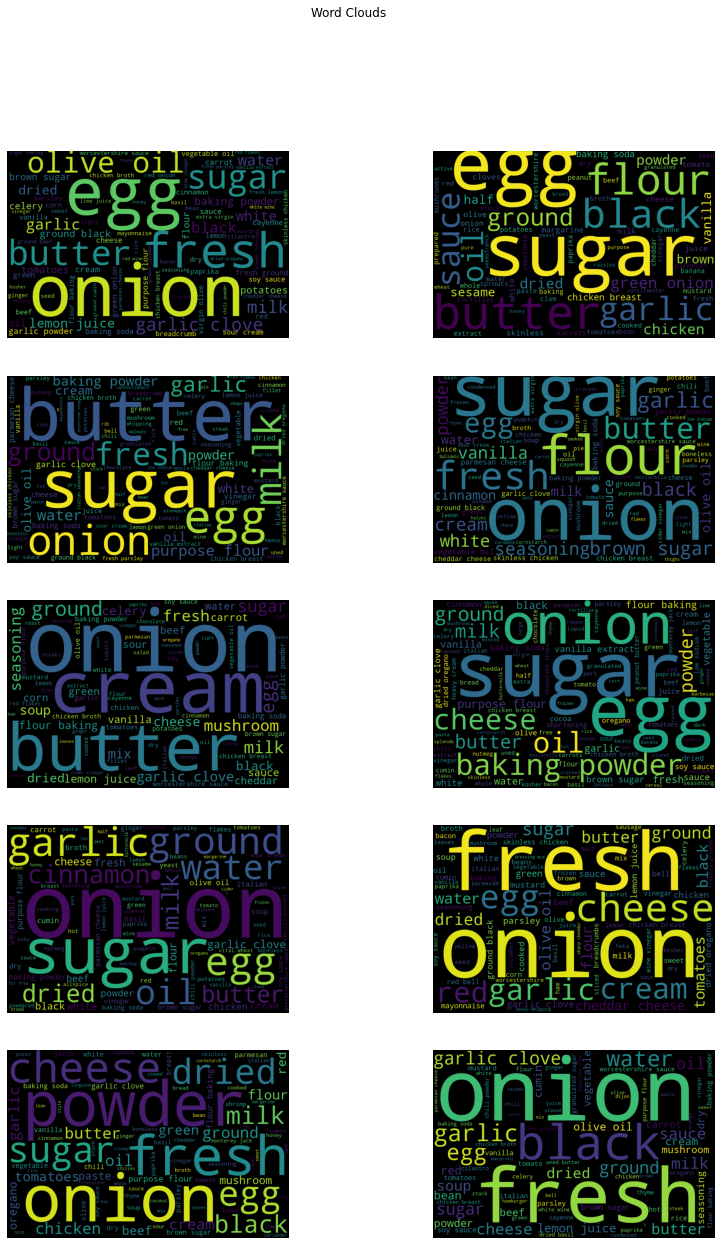

In [33]:
from collections import Counter


def ingredients_list(G_C1):
    #return ingredients list for recipies that are part of the graph

    #find 
    recipies = [recipe['recipe_id'] for node1, node2, recipe in G_C1.edges(data=True)]

    c_recipies=np.unique(np.array(recipies))
    #IN PROGRESS - Ingredients workclouds
    ing=''.join(''.join(df_recipes[df_recipes['id'].isin(c_recipies)].ingredients_str.values))
    return ing


fig = plt.figure(figsize=(14, 20))
fig.patch.set_alpha(0.0)    
fig.suptitle('Word Clouds')

k=0

for community_idx in list_largest_com:

    GC_subgraph = community_subgraph(community_idx)
    ingredients = ingredients_list(GC_subgraph)
    ing_list = ingredients.split(" ")
    

    #print(f'Top 10 ingredients for community {community_idx}:')

    counter =Counter(ing_list)
    top_10=counter.most_common(10)
    
    #print(top_10)

    #remove onion, salt, pepper - most common ing in every community
    ingredients = ingredients.replace('salt', "").replace('pepper', "")

    
    word_cloud = WordCloud(width=900,
                           height=600,
                           #background_color='white',
                           min_font_size=14).generate(ingredients)

    plt.subplot(5, 2, k + 1)
    plt.imshow(word_cloud)
    plt.axis('off')
    
    k+=1
    

In [34]:

from nltk.probability import FreqDist

# Calculate TF and extract 5 most common words for each of the 10 communities in the marvel universe
def TF_com(dic_texts, printing=False):
     # List to store all TF for every community in the dictionary of texts
    TF_com_global = []
    for key, value in dic_texts.items():
        #TF for 1 community
        TF_com = FreqDist(value)
        TF_com_global.append(TF_com)
         #Most common 5 words for 1 community
        most_common_marvel_com = TF_com.most_common(5)
        print(f'Community {key}')
        print(most_common_marvel_com)
    return TF_com_global

TF_com_global = []

for community_idx in list_largest_com:

    GC_subgraph = community_subgraph(community_idx)
    ingredients = ingredients_list(GC_subgraph)
    ingredients = ingredients.replace('salt ', "").replace('pepper ', "")

    ing_list = ingredients.split(" ")


    #print(f'Top 10 ingredients for community {community_idx}:')

    counter =Counter(ing_list )
    top_10=counter.most_common(10)

    TF_com = FreqDist(ing_list)
    TF_com_global.append(TF_com)

    #Most common 5 words for 1 community
    most_common_marvel_com = TF_com.most_common(10)
    #print(f'Community {community_idx}')
    #print(most_common_marvel_com)
    #print(top_10)




Community 16.0
[('garlic', 171), ('oil', 157), ('fresh', 156), ('ground', 140), ('onion', 136), ('sugar', 135), ('powder', 104), ('butter', 101), ('black', 97), ('olive', 88)]
[('garlic', 171), ('oil', 157), ('fresh', 156), ('ground', 140), ('onion', 136), ('sugar', 135), ('powder', 104), ('butter', 101), ('black', 97), ('olive', 88)]
Community 5.0
[('sugar', 11), ('butter', 10), ('chicken', 9), ('flour', 8), ('green', 7), ('black', 7), ('garlic', 7), ('sauce', 7), ('eggs', 6), ('baking', 6)]
[('sugar', 11), ('butter', 10), ('chicken', 9), ('flour', 8), ('green', 7), ('black', 7), ('garlic', 7), ('sauce', 7), ('eggs', 6), ('baking', 6)]
Community 3.0
[('sugar', 52), ('butter', 46), ('powder', 41), ('garlic', 40), ('flour', 37), ('baking', 37), ('oil', 35), ('ground', 33), ('fresh', 32), ('cheese', 30)]
[('sugar', 52), ('butter', 46), ('powder', 41), ('garlic', 40), ('flour', 37), ('baking', 37), ('oil', 35), ('ground', 33), ('fresh', 32), ('cheese', 30)]
Community 40.0
[('sugar', 37), 

In [35]:
import math
# Calculate IDF for each of the communities 
def IDF_com(TF_com_global,N):
    IDF_global = []
    for i in range(N):
        IDF = []
        for term, term_freq in TF_com_global[i].items():
            term_IDF = math.log(float(N) / term_freq + 1)
            IDF.append((term,term_IDF))
        IDF_global.append(IDF)

    return IDF_global

IDF_global = IDF_com(TF_com_global,N=10)

# Sort TF words to match the order of the IDF lists
TF_com_global_sorted = []
N=10
for i in range(N):
        TF_com_sorted = [] 
        for term, term_freq in TF_com_global[i].items():
                elem = (term,term_freq)
                #list of sorted words and freq of 1 comunnity
                TF_com_sorted.append(elem)
        # append it to the list of lists
        TF_com_global_sorted.append(TF_com_sorted)

# Calculate TF-IDF for each of the communities

def TF_IDF_com(TF_com_global_sorted,IDF_global):
    
    TF_IDF_global = []

    for i in range(N):
        # convert to dict to multiply easy
        dict_1 = dict(TF_com_global_sorted[i])
        dict_2 = dict(IDF_global[i])
        result = {key: dict_1[key] * dict_2[key] for key in dict_1}
        
        #Append it to the list of communities
        TF_IDF_global.append(result) 
    return TF_IDF_global

# finally returns list
TF_IDF_global = TF_IDF_com(TF_com_global_sorted,IDF_global)

In [49]:
#TF_IDF_global[0].values.sort()
dict(sorted(TF_IDF_global[1].items(), key=lambda item: item[1], reverse=True))

{'sugar': 7.112898814175577,
 'butter': 6.931471805599453,
 'chicken': 6.72492961647199,
 'flour': 6.48744172973063,
 'green': 6.211122365006321,
 'black': 6.211122365006321,
 'garlic': 6.211122365006321,
 'sauce': 6.211122365006321,
 'eggs': 5.884975518070358,
 'baking': 5.884975518070358,
 'oil': 5.884975518070358,
 'onion': 5.884975518070358,
 'ground': 5.884975518070358,
 'egg': 5.493061443340549,
 'powder': 5.493061443340549,
 'soda': 5.011051873981472,
 'sesame': 5.011051873981472,
 'vanilla': 5.011051873981472,
 'brown': 5.011051873981472,
 'dried': 5.011051873981472,
 'white': 4.3990112063802815,
 'olive': 4.3990112063802815,
 'milk': 4.3990112063802815,
 'margarine': 4.3990112063802815,
 'skinless': 4.3990112063802815,
 'breasts': 4.3990112063802815,
 'onions': 4.3990112063802815,
 'juice': 4.3990112063802815,
 'cloves': 4.3990112063802815,
 'cheese': 4.3990112063802815,
 'tomato': 4.3990112063802815,
 'whole': 3.58351893845611,
 'extract': 3.58351893845611,
 'tomatoes': 3.583

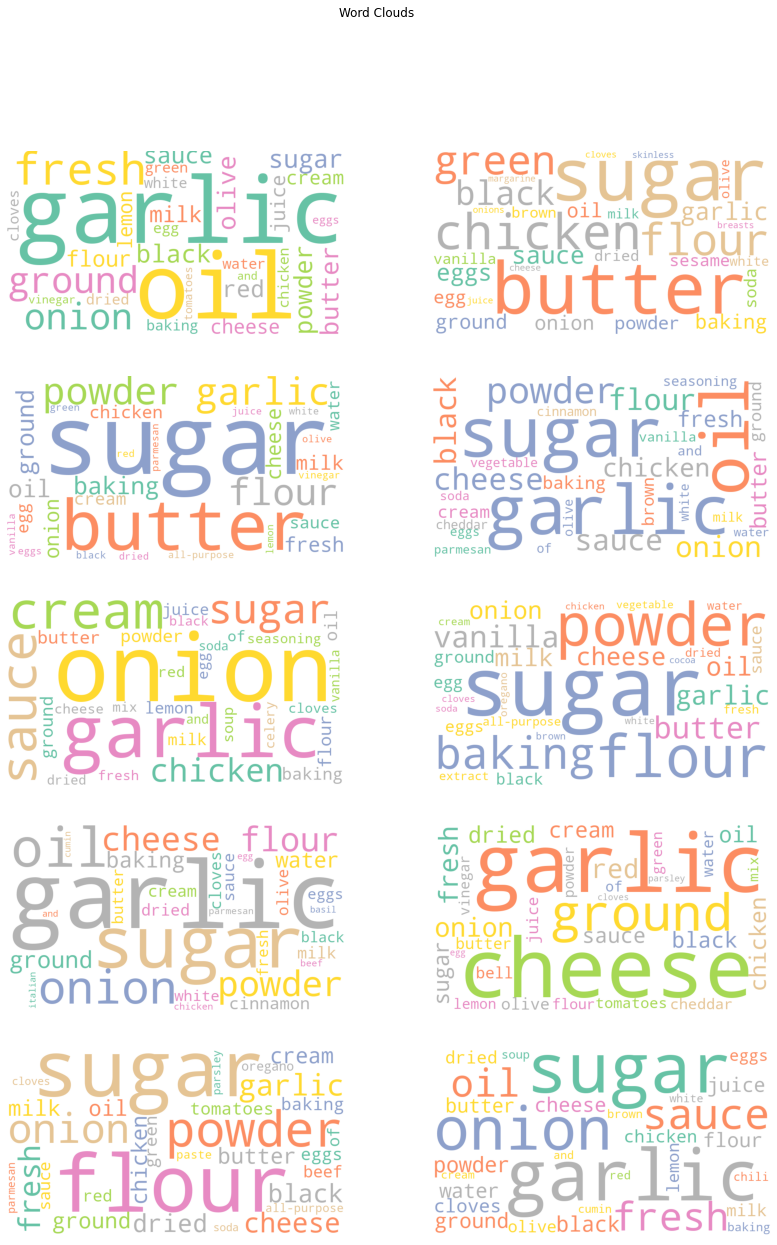

In [42]:
fig = plt.figure(figsize=(14, 20))
fig.patch.set_alpha(0.0)    
fig.suptitle('Word Clouds')

k=0

for i in range(len(list_largest_com)):


    word_cloud = WordCloud(width=900,height=500, 
                            max_words=30,
                            background_color='white',
                            colormap= 'Set2',
                            collocations= False,
                            relative_scaling=1,
                            normalize_plurals=False).fit_words(TF_IDF_global[i])

    plt.subplot(5, 2, k + 1)
    plt.tick_params(which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        labelbottom=False,
                        left= False,
                        labelleft = False) # labels along the bottom edge are off
    plt.imshow(word_cloud)
    plt.axis('off')
    
    k+=1

In [37]:
def create_inv_community_graph(community_idx):
    GC_subgraph = community_subgraph(community_idx)
    community_users = GC_subgraph.nodes
    recipies_community = [recipe['recipe_id'] for node1, node2, recipe in GC_subgraph.edges(data=True)]


    user_recipies_dict={id: [] for id in community_users}

    df_reviews_filter_community = df_reviews_filter[(df_reviews_filter['user_id'].isin(community_users)) & (df_reviews_filter['recipe_id'].isin(recipies_community))]



    for idx, row in tqdm(df_reviews_filter_community.iterrows()): 
        try:
            #for ingredient in row['ingredient_ids']:
            user_recipies_dict[row['user_id']].append(row['recipe_id'])
        except:
            recipe_error.append(row['user_id'])
#print(user_recipies_dict)

    edges_community = [(x,y, {"user_id": key})  for key in user_recipies_dict for x, y in list(combinations(user_recipies_dict[key], 2))] 
    G_inverse = nx.MultiDiGraph()
    G_inverse.add_nodes_from(recipies_community)
    G_inverse.add_edges_from(edges_community)

    return G_inverse

In [38]:
for community_idx in list_largest_com:
    graph = create_inv_community_graph(community_idx)
    d_c=nx.degree_centrality(graph)
    sorted_centrality= sorted(d_c.items(), key=lambda x: x[1], reverse=True)
    most_common_recipe_id = sorted_centrality[0][0]
    recipe_highest_centrality = df_recipes.loc[df_recipes['id'] == most_common_recipe_id]
    print(f'The recipe with highest centrality is - {recipe_highest_centrality.iloc[0][0]}')
    

1718it [00:00, 31846.23it/s]


The recipe with highest centrality is - jumbo shrimp parmesan


764it [00:00, 34648.30it/s]


The recipe with highest centrality is - best banana bread


806it [00:00, 33519.83it/s]


The recipe with highest centrality is - easy moist banana blueberry muffins


635it [00:00, 33341.47it/s]


The recipe with highest centrality is - honey garlic chicken thighs


571it [00:00, 34704.86it/s]


The recipe with highest centrality is - simple baked chicken drumsticks


534it [00:00, 34150.47it/s]


The recipe with highest centrality is - better than olive garden alfredo sauce


532it [00:00, 35350.11it/s]


The recipe with highest centrality is - copycat olive garden minestrone soup by todd wilbur


527it [00:00, 29233.43it/s]

The recipe with highest centrality is - olive garden copycat zuppa toscana



494it [00:00, 35176.84it/s]


The recipe with highest centrality is - creamy cajun chicken pasta


534it [00:00, 35403.36it/s]


The recipe with highest centrality is - easy stove top macaroni   cheese


# NLP Analysis of Reviews' text

___________________________________

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import os
import sys
sys.path.append(os.path.abspath("/Users/lucialarraona/Desktop/finalproject_socialgraphs22/Notebooks"))

from helper_functions import  *

import nltk 
from nltk.stem import PorterStemmer # para ver la raiz de las palabras(worker = work)
from nltk.tokenize import sent_tokenize, word_tokenize # para tokenizar las frases y las palabras 
import re # regex
import string

nltk.download('omw-1.4') #needed for lemmatizing

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer # an nltk package for sentiment analysis :D

import warnings
warnings.filterwarnings("ignore")

import plotly.express as px
from statistics import mean

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/lucialarraona/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lucialarraona/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# With the reviews dataset, map the community for each user 
df_reviews = decompress_pickle('../Data/reviews_zipped.pbz2') 
print(df_reviews.shape)
df_reviews.head()

(1132367, 5)


,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [3]:
df_recipes = decompress_pickle('../Data/file4.pbz2') 
df_ingredients = pd.read_csv('../Data/ingredients_with_recipies.csv')

In [4]:
df_recipes = df_recipes.rename(columns={'id':'recipe_id'})
df_recipes.head()

,name,recipe_id,minutes,ingredients,n_ingredients,ingredient_ids
0,arriba baked winter squash mexican style,137739,55,"[winter squash, mexican seasoning, mixed spice...",7,"[7933, 4694, 4795, 3723, 840, 5006, 6270]"
1,a bit different breakfast pizza,31490,30,"[prepared pizza crust, sausage patty, eggs, mi...",6,"[5481, 6324, 2499, 4717, 6276, 1170]"
2,alouette potatoes,59389,45,"[spreadable cheese with garlic and herbs, new ...",11,"[1170, 4918, 6426, 5185, 7099, 5006, 6009, 627..."
3,apple a day milk shake,5289,0,"[milk, vanilla ice cream, frozen apple juice c...",4,"[4717, 7474, 2946, 150]"
4,aww marinated olives,25274,15,"[fennel seeds, green olives, ripe olives, garl...",9,"[2587, 3437, 5002, 3184, 5324, 5068, 5058, 131..."


5    816364
4    187360
0     60847
3     40855
2     14123
1     12818
Name: rating, dtype: int64


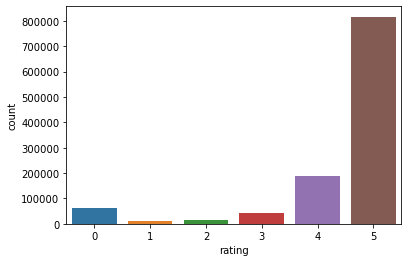

In [5]:
import seaborn as sns
sns.countplot(x='rating', data=df_reviews)
None
print(df_reviews['rating'].value_counts())

In [6]:
df_com_map = pd.read_csv('user_community_map.csv')
print(df_com_map.shape)
df_com_map.head()

(15257, 2)


,user_id,community
0,1535,3.0
1,3288,52.0
2,4439,16.0
3,4470,16.0
4,4769,35.0


In [7]:
df_reviews_raw = pd.merge(df_com_map, df_reviews, how="left", on=["user_id"]) # merging left is using only the keys on the left df, in this case df_com_map
print(df_reviews_raw.shape)
df_reviews_raw.head()

(144295, 6)


,user_id,community,recipe_id,date,rating,review
0,1535,3.0,349022,2010-02-11,4,"After being w/o power all day, it came back on..."
1,1535,3.0,50022,2004-09-09,5,This is an excellent recipe. Even my not-a-big...
2,1535,3.0,78834,2005-02-02,5,Made these for my kids one day as a surprise a...
3,1535,3.0,47474,2004-08-04,5,Love them!! A quick & easy recipe with ingredi...
4,1535,3.0,230720,2007-07-02,5,I was a little afraid this might not work very...


In [10]:
df_reviews_raw = pd.merge(df_reviews_raw, df_recipes, how='left',on =['recipe_id'])
df_reviews_raw = df_reviews_raw.dropna()
df_reviews_raw.head()

,user_id,community,recipe_id,date,rating,review,name_x,minutes_x,ingredients_x,n_ingredients_x,ingredient_ids_x,name_y,minutes_y,ingredients_y,n_ingredients_y,ingredient_ids_y
0,1535,3.0,349022,2010-02-11,4,"After being w/o power all day, it came back on...",slow cooker chicken tomato and white bean soup,495.0,"[onion, celery ribs, carrots, garlic, salt, bl...",14.0,"[5010, 1130, 1093, 3184, 6270, 590, 1708, 840,...",slow cooker chicken tomato and white bean soup,495,"[onion, celery ribs, carrots, garlic, salt, bl...",14,"[5010, 1130, 1093, 3184, 6270, 590, 1708, 840,..."
1,1535,3.0,50022,2004-09-09,5,This is an excellent recipe. Even my not-a-big...,the best banana bread,85.0,"[butter, sugar, bananas, eggs, vanilla, baking...",10.0,"[840, 6906, 342, 2499, 7449, 335, 2683, 6270, ...",the best banana bread,85,"[butter, sugar, bananas, eggs, vanilla, baking...",10,"[840, 6906, 342, 2499, 7449, 335, 2683, 6270, ..."
2,1535,3.0,47474,2004-08-04,5,Love them!! A quick & easy recipe with ingredi...,lemon cooler cookies,33.0,"[powdered sugar, sugar, shortening, egg, vanil...",10.0,"[5695, 6906, 6473, 2499, 7449, 6270, 911, 332,...",lemon cooler cookies,33,"[powdered sugar, sugar, shortening, egg, vanil...",10,"[5695, 6906, 6473, 2499, 7449, 6270, 911, 332,..."
3,1535,3.0,230720,2007-07-02,5,I was a little afraid this might not work very...,red white and blue jello flag,260.0,"[boiling water, berry blue gelatin mix, gelati...",6.0,"[673, 525, 3234, 1645, 4249, 1792]",red white and blue jello flag,260,"[boiling water, berry blue gelatin mix, gelati...",6,"[673, 525, 3234, 1645, 4249, 1792]"
4,1535,3.0,87461,2004-10-26,5,This was incredible!! It is the best garlic br...,my own garlic bread,30.0,"[french bread, margarine, mayonnaise, garlic s...",5.0,"[2718, 4574, 4623, 3219, 5180]",my own garlic bread,30,"[french bread, margarine, mayonnaise, garlic s...",5,"[2718, 4574, 4623, 3219, 5180]"


In [12]:
# Make a copy to keep the raw dataframe for the future 
df_reviews2 = df_reviews_raw.reset_index(drop=True)

## Cleaning text 

In [13]:
def text_cleaning(text):
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

stopwords = nltk.corpus.stopwords.words('english')

ps = PorterStemmer()
wn = nltk.WordNetLemmatizer()

def clean_stem (review):

    temp1 ="".join(x for x in review if x not in string.punctuation)
    temp2 = re.split('\W+',temp1.lower())
    temp3 = [ps.stem(x) for x in temp2 if x not in stopwords]
    return temp3


def clean_lemma (review):
    
    temp1 ="".join(x for x in review if x not in string.punctuation)
    temp2 = re.split('\W+',temp1.lower())
    temp3 = [wn.lemmatize(x) for x in temp2 if x not in stopwords]
    return temp3


df_reviews2['review'] =df_reviews2['review'] .astype('str')  # object to string
df_reviews2['review'] = df_reviews2['review'] .apply(text_cleaning) # cleaning 
df_reviews2['review_tokens']= df_reviews2['review'].map(clean_lemma) # apply lemmatization for now
df_reviews2.head()

,user_id,community,recipe_id,date,rating,review,name_x,minutes_x,ingredients_x,n_ingredients_x,ingredient_ids_x,name_y,minutes_y,ingredients_y,n_ingredients_y,ingredient_ids_y,review_tokens
0,1535,3.0,349022,2010-02-11,4,after being w o power all day it came back on...,slow cooker chicken tomato and white bean soup,495.0,"[onion, celery ribs, carrots, garlic, salt, bl...",14.0,"[5010, 1130, 1093, 3184, 6270, 590, 1708, 840,...",slow cooker chicken tomato and white bean soup,495,"[onion, celery ribs, carrots, garlic, salt, bl...",14,"[5010, 1130, 1093, 3184, 6270, 590, 1708, 840,...","[w, power, day, came, back, right, bedtime, qu..."
1,1535,3.0,50022,2004-09-09,5,this is an excellent recipe even my not a big...,the best banana bread,85.0,"[butter, sugar, bananas, eggs, vanilla, baking...",10.0,"[840, 6906, 342, 2499, 7449, 335, 2683, 6270, ...",the best banana bread,85,"[butter, sugar, bananas, eggs, vanilla, baking...",10,"[840, 6906, 342, 2499, 7449, 335, 2683, 6270, ...","[excellent, recipe, even, big, fan, banana, br..."
2,1535,3.0,47474,2004-08-04,5,love them a quick easy recipe with ingredi...,lemon cooler cookies,33.0,"[powdered sugar, sugar, shortening, egg, vanil...",10.0,"[5695, 6906, 6473, 2499, 7449, 6270, 911, 332,...",lemon cooler cookies,33,"[powdered sugar, sugar, shortening, egg, vanil...",10,"[5695, 6906, 6473, 2499, 7449, 6270, 911, 332,...","[love, quick, easy, recipe, ingredient, always..."
3,1535,3.0,230720,2007-07-02,5,i was a little afraid this might not work very...,red white and blue jello flag,260.0,"[boiling water, berry blue gelatin mix, gelati...",6.0,"[673, 525, 3234, 1645, 4249, 1792]",red white and blue jello flag,260,"[boiling water, berry blue gelatin mix, gelati...",6,"[673, 525, 3234, 1645, 4249, 1792]","[little, afraid, might, work, well, turned, lo..."
4,1535,3.0,87461,2004-10-26,5,this was incredible it is the best garlic br...,my own garlic bread,30.0,"[french bread, margarine, mayonnaise, garlic s...",5.0,"[2718, 4574, 4623, 3219, 5180]",my own garlic bread,30,"[french bread, margarine, mayonnaise, garlic s...",5,"[2718, 4574, 4623, 3219, 5180]","[incredible, best, garlic, bread, ever, made, ..."


In [14]:
#//// Sanity check of differneces between lemmatizing and stemming
print(df_reviews2['review'][1])
print(clean_lemma(df_reviews2['review'][1]))
print()
print(df_reviews2['review'][1])
print(clean_stem(df_reviews2['review'][1]))

this is an excellent recipe  even my not a big fan of banana bread husband had seconds  i used nuts instead of chocolate chips and made two loaves  next time i ll check it before  minutes as it was a bit brown  i ll also make sure i grease and flour the pan as it stuck with just using spray  i want to make sure i try it sometime with real buttermilk instead of the soured milk  i m sure real will make it even better  a keeper for sure    update  this time i made it with the chocolate chips   while they didn t take away from the bread  i m not sure they really added to it either  i made one loaf this time and used real buttermilk  fantastic  definitely deserves the title  the best banana bread 
['excellent', 'recipe', 'even', 'big', 'fan', 'banana', 'bread', 'husband', 'second', 'used', 'nut', 'instead', 'chocolate', 'chip', 'made', 'two', 'loaf', 'next', 'time', 'check', 'minute', 'bit', 'brown', 'also', 'make', 'sure', 'grease', 'flour', 'pan', 'stuck', 'using', 'spray', 'want', 'make'

## Calculate Sentiment of text

In [15]:
sid = SentimentIntensityAnalyzer()


# Sentiment compound value of reviews
def sentiment(x):
    score = sid.polarity_scores(x)
    return score['compound']


#  Add Positive y Negative tag 
def cls(x):
    list1=[]
    for i in x["score"]:
        if i>0:
            list1.append("Positive")
        elif i==0:
            list1.append("Neutral")
        else:
            list1.append("Negative")
    x["sentiment"]=list1



df_reviews2['score']= df_reviews2['review'].apply(lambda x : sentiment(x)) #score
cls(df_reviews2) # tag (for plotting)
df_reviews2.head() 

,user_id,community,recipe_id,date,rating,review,name_x,minutes_x,ingredients_x,n_ingredients_x,ingredient_ids_x,name_y,minutes_y,ingredients_y,n_ingredients_y,ingredient_ids_y,review_tokens,score,sentiment
0,1535,3.0,349022,2010-02-11,4,after being w o power all day it came back on...,slow cooker chicken tomato and white bean soup,495.0,"[onion, celery ribs, carrots, garlic, salt, bl...",14.0,"[5010, 1130, 1093, 3184, 6270, 590, 1708, 840,...",slow cooker chicken tomato and white bean soup,495,"[onion, celery ribs, carrots, garlic, salt, bl...",14,"[5010, 1130, 1093, 3184, 6270, 590, 1708, 840,...","[w, power, day, came, back, right, bedtime, qu...",0.8481,Positive
1,1535,3.0,50022,2004-09-09,5,this is an excellent recipe even my not a big...,the best banana bread,85.0,"[butter, sugar, bananas, eggs, vanilla, baking...",10.0,"[840, 6906, 342, 2499, 7449, 335, 2683, 6270, ...",the best banana bread,85,"[butter, sugar, bananas, eggs, vanilla, baking...",10,"[840, 6906, 342, 2499, 7449, 335, 2683, 6270, ...","[excellent, recipe, even, big, fan, banana, br...",0.9707,Positive
2,1535,3.0,47474,2004-08-04,5,love them a quick easy recipe with ingredi...,lemon cooler cookies,33.0,"[powdered sugar, sugar, shortening, egg, vanil...",10.0,"[5695, 6906, 6473, 2499, 7449, 6270, 911, 332,...",lemon cooler cookies,33,"[powdered sugar, sugar, shortening, egg, vanil...",10,"[5695, 6906, 6473, 2499, 7449, 6270, 911, 332,...","[love, quick, easy, recipe, ingredient, always...",0.6486,Positive
3,1535,3.0,230720,2007-07-02,5,i was a little afraid this might not work very...,red white and blue jello flag,260.0,"[boiling water, berry blue gelatin mix, gelati...",6.0,"[673, 525, 3234, 1645, 4249, 1792]",red white and blue jello flag,260,"[boiling water, berry blue gelatin mix, gelati...",6,"[673, 525, 3234, 1645, 4249, 1792]","[little, afraid, might, work, well, turned, lo...",0.9722,Positive
4,1535,3.0,87461,2004-10-26,5,this was incredible it is the best garlic br...,my own garlic bread,30.0,"[french bread, margarine, mayonnaise, garlic s...",5.0,"[2718, 4574, 4623, 3219, 5180]",my own garlic bread,30,"[french bread, margarine, mayonnaise, garlic s...",5,"[2718, 4574, 4623, 3219, 5180]","[incredible, best, garlic, bread, ever, made, ...",0.8860,Positive


In [16]:
import plotly as ply
import plotly.graph_objs as go

Mno=df_reviews2[df_reviews2.sentiment=="Positive"]["score"].count()
Fno=df_reviews2[df_reviews2.sentiment=="Negative"]["score"].count()
Nno=df_reviews2[df_reviews2.sentiment=="Neutral"]["score"].count()
labels = ["Positive Comments","Negative Comments","Neutral Comments"]
values = [Mno,Fno,Nno]
fig = go.Figure(data=[go.Pie(labels=labels, values=values,hole=0.4)])
fig.show()

## Reescaling the sentiment as a new rating score (1-5)

In [17]:
# Rescaling the score to 0-1 and then divinding by 5 to match the range of the rating and comapre

from sklearn.preprocessing import minmax_scale

df_reviews2[['score_scale']] = minmax_scale(df_reviews2[['score']])
df_reviews2[['score_scale2']] = df_reviews2[['score_scale']]*5
df_reviews2

,user_id,community,recipe_id,date,rating,review,name_x,minutes_x,ingredients_x,n_ingredients_x,...,name_y,minutes_y,ingredients_y,n_ingredients_y,ingredient_ids_y,review_tokens,score,sentiment,score_scale,score_scale2
0,1535,3.0,349022,2010-02-11,4,after being w o power all day it came back on...,slow cooker chicken tomato and white bean soup,495.0,"[onion, celery ribs, carrots, garlic, salt, bl...",14.0,...,slow cooker chicken tomato and white bean soup,495,"[onion, celery ribs, carrots, garlic, salt, bl...",14,"[5010, 1130, 1093, 3184, 6270, 590, 1708, 840,...","[w, power, day, came, back, right, bedtime, qu...",0.8481,Positive,0.923671,4.618357
1,1535,3.0,50022,2004-09-09,5,this is an excellent recipe even my not a big...,the best banana bread,85.0,"[butter, sugar, bananas, eggs, vanilla, baking...",10.0,...,the best banana bread,85,"[butter, sugar, bananas, eggs, vanilla, baking...",10,"[840, 6906, 342, 2499, 7449, 335, 2683, 6270, ...","[excellent, recipe, even, big, fan, banana, br...",0.9707,Positive,0.985603,4.928016
2,1535,3.0,47474,2004-08-04,5,love them a quick easy recipe with ingredi...,lemon cooler cookies,33.0,"[powdered sugar, sugar, shortening, egg, vanil...",10.0,...,lemon cooler cookies,33,"[powdered sugar, sugar, shortening, egg, vanil...",10,"[5695, 6906, 6473, 2499, 7449, 6270, 911, 332,...","[love, quick, easy, recipe, ingredient, always...",0.6486,Positive,0.822894,4.114468
3,1535,3.0,230720,2007-07-02,5,i was a little afraid this might not work very...,red white and blue jello flag,260.0,"[boiling water, berry blue gelatin mix, gelati...",6.0,...,red white and blue jello flag,260,"[boiling water, berry blue gelatin mix, gelati...",6,"[673, 525, 3234, 1645, 4249, 1792]","[little, afraid, might, work, well, turned, lo...",0.9722,Positive,0.986361,4.931804
4,1535,3.0,87461,2004-10-26,5,this was incredible it is the best garlic br...,my own garlic bread,30.0,"[french bread, margarine, mayonnaise, garlic s...",5.0,...,my own garlic bread,30,"[french bread, margarine, mayonnaise, garlic s...",5,"[2718, 4574, 4623, 3219, 5180]","[incredible, best, garlic, bread, ever, made, ...",0.8860,Positive,0.942817,4.714084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123663,2002371420,39.0,50245,2018-12-18,5,made this with a slight variation added the p...,chicken francese,35.0,"[boneless skinless chicken breasts, condensed ...",11.0,...,chicken francese,35,"[boneless skinless chicken breasts, condensed ...",11,"[1252, 1257, 7801, 4287, 2499, 5180, 2683, 320...","[made, slight, variation, added, parmesan, che...",0.0000,Neutral,0.495252,2.476258
123664,2002371445,5.0,2886,2018-12-19,5,i ve been using this recipe for years and its...,best banana bread,65.0,"[butter, granulated sugar, eggs, bananas, all-...",8.0,...,best banana bread,65,"[butter, granulated sugar, eggs, bananas, all-...",8,"[840, 3355, 2499, 342, 63, 335, 6270, 7449]","[using, recipe, year, one, use, tried, several...",0.1779,Positive,0.585118,2.925591
123665,2002371627,52.0,153647,2018-12-19,0,best thing about this recipe i didn t have to...,tortilla crusted tilapia,30.0,"[tilapia fillets, corn tortillas, jalapeno pep...",9.0,...,tortilla crusted tilapia,30,"[tilapia fillets, corn tortillas, jalapeno pep...",9,"[7178, 7258, 3957, 4384, 2777, 1329, 3502, 637...","[best, thing, recipe, scroll, past, rambling, ...",0.9572,Positive,0.978784,4.893918
123666,2002371843,61.0,516662,2018-12-19,5,this cake is incredible tasting and easy to ma...,black bean chocolate cake,65.0,"[black beans, eggs, pure vanilla extract, sea ...",9.0,...,black bean chocolate cake,65,"[black beans, eggs, pure vanilla extract, sea ...",9,"[553, 2499, 5767, 6352, 1609, 3723, 2485, 332,...","[cake, incredible, tasting, easy, make, froste...",0.8519,Positive,0.925591,4.627955


### Plot distribution of true rating

The mean of the sentiment in the reviews: 4.464267231620144
90th percentile of the sentiment:  5.0
10th percentile of the sentiment:  4.0


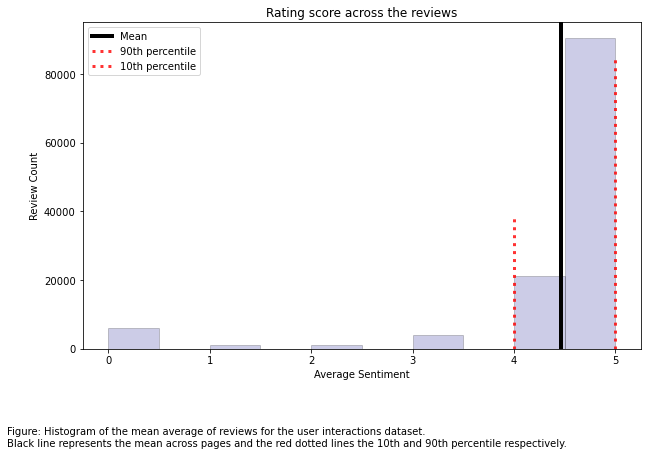

In [18]:
# Mean, 10th and 90th percentile of the sentiment

mean_rev= df_reviews2['rating'].describe()['mean']

print(f'The mean of the sentiment in the reviews: {mean_rev}')
print("90th percentile of the sentiment: ",
       np.percentile(df_reviews2['rating'], 90))

print("10th percentile of the sentiment: ",
       np.percentile(df_reviews2['rating'], 10))


# Add the percentiles to a list for the plotting
percentiles = [np.percentile(df_reviews2['rating'], 90), np.percentile(df_reviews2['rating'], 10)]


# Plotting 
list_sentiment = list(zip(df_reviews2['user_id'], df_reviews2['rating']))

def plot_pretty_hist(list_data, percentiles, mean, plot_perct = False, title = str, color=str):

    x = [val for (node, val) in list_data]
    fig,ax = plt.subplots(figsize = (10,6))
    cnts, values, bars = ax.hist(x, edgecolor='black', 
                                        bins=10,
                                        color=color,
                                        alpha = 0.2)

    if plot_perct == True:
        # Plot mean
        ax.axvline(mean, color='black', linestyle = '-', linewidth=4) 
        # Plot percentiles and mean lines
        quants = [[percentiles[0], 0.8, 0.90], [percentiles[1], 0.8, 0.40]]
        for i in quants:
            ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":", color = 'Red' ,linewidth=3)  

        
        # Labels and titles
        ax.set_ylabel("Review Count")
        ax.set_xlabel("Average Sentiment")
        ax.set_title(f"{title}")
        ax.legend(['Mean','90th percentile','10th percentile'])
        caption = ("Figure: Histogram of the mean average of reviews for the user interactions dataset.\n"
                    "Black line represents the mean across pages and the red dotted lines the 10th and 90th percentile respectively.")
        fig.text(0.02,-0.1, caption, ha='left')
        
        # Remove ticks and spines
        for ax, spine in ax.spines.items():
            spine.set_visible(True)
        plt.show()
        
        

    else:
        
        # Plot the mean
        ax.axvline(mean, color='black', linewidth=4) 
        
        # Labels and titles
        ax.set_ylabel("Page Count")
        ax.set_xlabel("Average Sentiment")
        ax.set_title(f"{title}")
        ax.legend(['Mean'])
        caption = ('haha')
        fig.text(0.02,-0.1, caption, ha='left')
        
        # Remove ticks and spines
        for ax, spine in ax.spines.items():
            spine.set_visible(True)
        plt.show()

    return None

plot_pretty_hist(list_sentiment,percentiles, mean_rev, plot_perct= True, 
                 title="Rating score across the reviews",
                 color = 'darkblue')

### Plot distribution of the new calculated rating

The mean of the sentiment in the reviews: 4.447517539791296
90th percentile of the sentiment:  4.938876540715297
10th percentile of the sentiment:  3.588603758335018


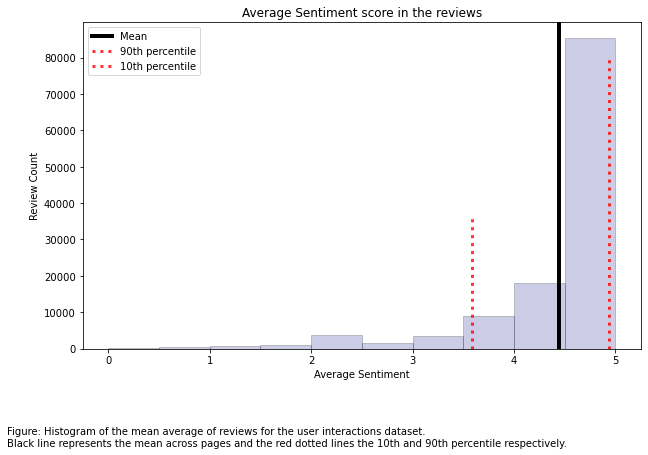

In [19]:
# Mean, 10th and 90th percentile of the sentiment

mean_rev= df_reviews2['score_scale2'].describe()['mean']

print(f'The mean of the sentiment in the reviews: {mean_rev}')
print("90th percentile of the sentiment: ",
       np.percentile(df_reviews2['score_scale2'], 90))

print("10th percentile of the sentiment: ",
       np.percentile(df_reviews2['score_scale2'], 10))


# Add the percentiles to a list for the plotting
percentiles = [np.percentile(df_reviews2['score_scale2'], 90), np.percentile(df_reviews2['score_scale2'], 10)]

list_sentiment = list(zip(df_reviews2['user_id'], df_reviews2['score_scale2']))

def plot_pretty_hist(list_data, percentiles, mean, plot_perct = False, title = str, color=str):

    x = [val for (node, val) in list_data]
    fig,ax = plt.subplots(figsize = (10,6))
    cnts, values, bars = ax.hist(x, edgecolor='black', 
                                        bins=10,
                                        color=color,
                                        alpha = 0.2)

    if plot_perct == True:
        # Plot mean
        ax.axvline(mean, color='black', linestyle = '-', linewidth=4) 
        # Plot percentiles and mean lines
        quants = [[percentiles[0], 0.8, 0.90], [percentiles[1], 0.8, 0.40]]
        for i in quants:
            ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":", color = 'Red' ,linewidth=3)  

        
        # Labels and titles
        ax.set_ylabel("Review Count")
        ax.set_xlabel("Average Sentiment")
        ax.set_title(f"{title}")
        ax.legend(['Mean','90th percentile','10th percentile'])
        caption = ("Figure: Histogram of the mean average of reviews for the user interactions dataset.\n"
                    "Black line represents the mean across pages and the red dotted lines the 10th and 90th percentile respectively.")
        fig.text(0.02,-0.1, caption, ha='left')
        
        # Remove ticks and spines
        for ax, spine in ax.spines.items():
            spine.set_visible(True)
        plt.show()
        
        

    else:
        
        # Plot the mean
        ax.axvline(mean, color='black', linewidth=4) 
        
        # Labels and titles
        ax.set_ylabel("Page Count")
        ax.set_xlabel("Average Sentiment")
        ax.set_title(f"{title}")
        ax.legend(['Mean'])
        caption = ('haha')
        fig.text(0.02,-0.1, caption, ha='left')
        
        # Remove ticks and spines
        for ax, spine in ax.spines.items():
            spine.set_visible(True)
        plt.show()

    return None


plot_pretty_hist(list_sentiment,percentiles, mean_rev, plot_perct= True, 
                title="Average Sentiment score in the reviews",
                color = 'darkblue')

### Label Permutation Test

> **Label permutation test to investigate the two hypotheses below**
>* **H1: Good reviews (>4 rating) have a higher averge value for sentiment than a similarly sized set of randomly rated reviews.**
>* **H2: Bad reviews (<4) have a lower average value for sentiment than a similarly sized set of randomly rated reviews.**
>* **Write a short paragraph reflecting on your findings.**

In [20]:
# We will relabel de dataset for easier permutation test analysis:
threshold = 3.5
df_reviews2['good'] = df_reviews2['score_scale2'].map(lambda x: 1 if x > threshold else 0)
df_reviews2['bad'] = df_reviews2['score_scale2'].map(lambda x: 1 if x < threshold else 0 )
df_reviews2.head()

,user_id,community,recipe_id,date,rating,review,name_x,minutes_x,ingredients_x,n_ingredients_x,...,ingredients_y,n_ingredients_y,ingredient_ids_y,review_tokens,score,sentiment,score_scale,score_scale2,good,bad
0,1535,3.0,349022,2010-02-11,4,after being w o power all day it came back on...,slow cooker chicken tomato and white bean soup,495.0,"[onion, celery ribs, carrots, garlic, salt, bl...",14.0,...,"[onion, celery ribs, carrots, garlic, salt, bl...",14,"[5010, 1130, 1093, 3184, 6270, 590, 1708, 840,...","[w, power, day, came, back, right, bedtime, qu...",0.8481,Positive,0.923671,4.618357,1,0
1,1535,3.0,50022,2004-09-09,5,this is an excellent recipe even my not a big...,the best banana bread,85.0,"[butter, sugar, bananas, eggs, vanilla, baking...",10.0,...,"[butter, sugar, bananas, eggs, vanilla, baking...",10,"[840, 6906, 342, 2499, 7449, 335, 2683, 6270, ...","[excellent, recipe, even, big, fan, banana, br...",0.9707,Positive,0.985603,4.928016,1,0
2,1535,3.0,47474,2004-08-04,5,love them a quick easy recipe with ingredi...,lemon cooler cookies,33.0,"[powdered sugar, sugar, shortening, egg, vanil...",10.0,...,"[powdered sugar, sugar, shortening, egg, vanil...",10,"[5695, 6906, 6473, 2499, 7449, 6270, 911, 332,...","[love, quick, easy, recipe, ingredient, always...",0.6486,Positive,0.822894,4.114468,1,0
3,1535,3.0,230720,2007-07-02,5,i was a little afraid this might not work very...,red white and blue jello flag,260.0,"[boiling water, berry blue gelatin mix, gelati...",6.0,...,"[boiling water, berry blue gelatin mix, gelati...",6,"[673, 525, 3234, 1645, 4249, 1792]","[little, afraid, might, work, well, turned, lo...",0.9722,Positive,0.986361,4.931804,1,0
4,1535,3.0,87461,2004-10-26,5,this was incredible it is the best garlic br...,my own garlic bread,30.0,"[french bread, margarine, mayonnaise, garlic s...",5.0,...,"[french bread, margarine, mayonnaise, garlic s...",5,"[2718, 4574, 4623, 3219, 5180]","[incredible, best, garlic, bread, ever, made, ...",0.8860,Positive,0.942817,4.714084,1,0


In [21]:
# Shuffle the good/bad attribute

avg_score_shuffle_good = []
avg_score_shuffle_bad = []
avg_score_good = []
avg_score_bad = []


for _ in range(1000):
    
    # Create a list of shuffled good attribute and append it to the df_reviews2
    df_reviews2['good_shuffled'] = np.random.permutation(df_reviews2['good'])
    df_reviews2['bad_shuffled'] = np.random.permutation(df_reviews2['bad'])
    
    # Create a new df for every iteration on the loop 
    df_test = pd.DataFrame() 
    df_test['user_id'] = df_reviews2['user_id']       #character
    df_test['good_true'] = df_reviews2['good']              #true labels
    df_test['bad_true'] = df_reviews2['bad'] # true labels
    df_test['good_shuffled'] = df_reviews2['good_shuffled'] #shuffled labels
    df_test['bad_shuffled'] = df_reviews2['bad_shuffled']  #shuffled labels
    df_test['score_scale2'] = df_reviews2['score_scale2']


    # group with just characters and shuffled labels (random group)
    shuffled_group_good = df_test[df_test['good_shuffled']== 1] # good characters
    avg_score_shuffle_good.append(np.mean(shuffled_group_good['score_scale2'])) 
    
    # group with just characters and shuffled labels (random group)
    shuffled_group_bad = df_test[df_test['bad_shuffled']== 1] # bad characters
    avg_score_shuffle_bad.append(np.mean(shuffled_group_bad['score_scale2']))

# group with just characters and their true labels 
true_group_good = df_reviews2[df_reviews2['good'] == 1]
avg_score_good = np.mean(true_group_good['score_scale2']) #it will always be the same number because of the true labels

# group with just characters and their true labels 
true_group_bad = df_reviews2[df_reviews2['bad'] == 1]
avg_score_bad = np.mean(true_group_bad['score_scale2']) #it will always be the same number because of the true labels

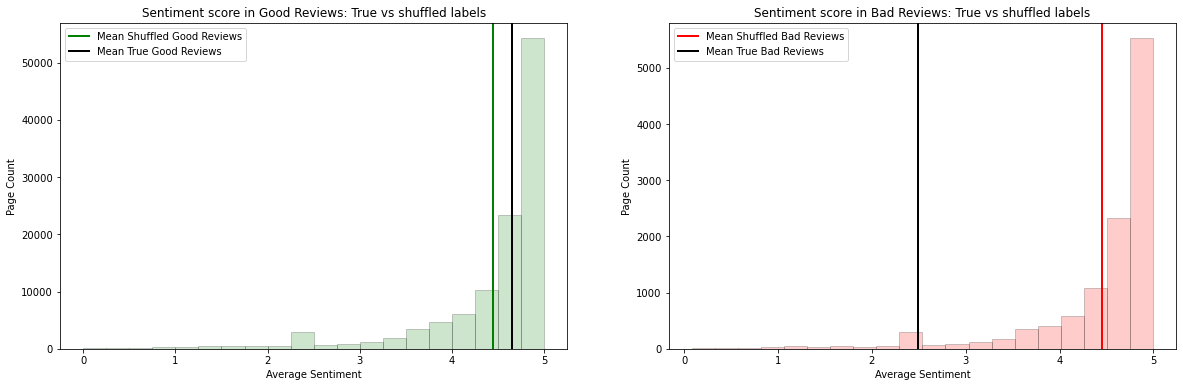

In [22]:
def plot_pretty_hist_pair(shuffled_group_good, true_group_good, shuffled_group_bad, true_group_bad):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,6))


    # H1
    list_shuffle_good = list(zip(shuffled_group_good['user_id'], shuffled_group_good['score_scale2']))
    x_good = [val for (node, val) in list_shuffle_good]
    
    cnts, values, bars = ax1.hist(x_good, edgecolor='black', 
                                     bins=20,
                                     color='green',
                                     alpha = 0.2)

    # Mean of shuffled labels
    ax1.axvline(mean(avg_score_shuffle_good), color='green', linewidth=2)
    # Mean of true labels
    ax1.axvline(avg_score_good, color='black', linewidth=2)

    # Labels and titles
    ax1.set_ylabel("Page Count")
    ax1.set_xlabel("Average Sentiment")
    ax1.set_title("Sentiment score in Good Reviews: True vs shuffled labels")
    ax1.legend(['Mean Shuffled Good Reviews','Mean True Good Reviews'])


    
    
    # ----------------------------
    
    # H2
    list_shuffle = list(zip(shuffled_group_bad['user_id'], shuffled_group_bad['score_scale2']))
    x = [val for (node, val) in list_shuffle]
    cnts, values, bars = ax2.hist(x, edgecolor='black', 
                                     bins=20,
                                     color='red',
                                     alpha = 0.2)
    # Mean of shuffled labels
    ax2.axvline(mean(avg_score_shuffle_bad), color='red', linewidth=2) 
    # Mean of true labels
    ax2.axvline(avg_score_bad, color='black', linewidth=2) 
    

    # Labels and titles
    ax2.set_ylabel("Page Count")
    ax2.set_xlabel("Average Sentiment")
    ax2.set_title("Sentiment score in Bad Reviews: True vs shuffled labels")
    ax2.legend(['Mean Shuffled Bad Reviews','Mean True Bad Reviews'])


    plt.show()

    pass

    return None


plot_pretty_hist_pair(shuffled_group_good, true_group_good, shuffled_group_bad, true_group_bad)